# Loading packages

In [1]:
import numpy as np 
import pandas as pd 
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.decomposition import PCA

# Image preprocessing

In [2]:
num_skipped = 0
for folder_name in ("Cats", "Dogs"):
    folder_path = os.path.join('/Users/chiarasaini/Desktop/CatsDogs', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
PATH = '/Users/chiarasaini/Desktop/CatsDogs/'
CATEGORIES = ['Cats', 'Dogs']

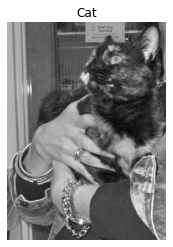

In [4]:
for category in CATEGORIES:                                                   
    path = os.path.join(PATH, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.title('Cat')
        plt.axis('off')
        plt.show()
        break
    break

In [5]:
print(img_array)

[[174 175 177 ... 134 133 132]
 [175 176 178 ... 135 134 132]
 [177 178 179 ... 137 136 134]
 ...
 [ 56  55  58 ... 168 165 174]
 [ 57  56  58 ... 157 150 153]
 [ 58  56  58 ... 156 143 139]]


In [6]:
print(img_array.shape)

(500, 365)


Text(0.5, 0, 'shape: (180, 180)')

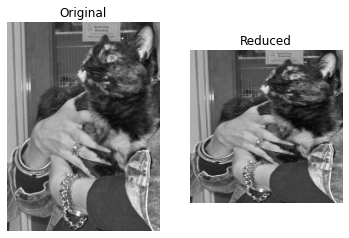

In [7]:

plt.subplot(1,2,1)
plt.imshow(img_array, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.xlabel('shape: {}'.format(img_array.shape))
plt.subplot(1,2,2)

IMG_SIZE = 180
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.title('Reduced')
plt.axis('off')
plt.xlabel('shape: {}'.format(new_array.shape))

In [8]:
training_data = []
class_list =[]

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(PATH,category) 
        class_num = CATEGORIES.index(category)  
        for img in os.listdir(path):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, class_num])  
                class_list.append(class_num)
            except Exception as e:  
                pass
            

create_training_data()

print(len(training_data))

23410


/Users/davidev7/miniforge3/envs/ch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

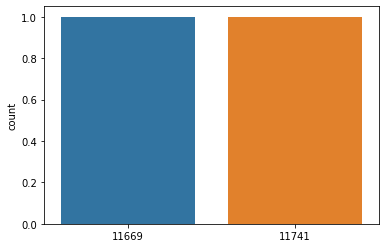

In [9]:
# There seems to be little class imbalance
sns.countplot(pd.Series(class_list).value_counts())

In [10]:
import random

random.shuffle(training_data)

In [11]:
# check if sample worked
for sample in training_data[:10]:
    print(sample[1])

1
0
0
1
0
1
1
0
1
1


In [12]:
X = []
y = []

for features, labels in training_data:
    X.append(features)
    y.append(labels)

    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y) # labels

# normalising the data
X = X/255

# Train-test split

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20)

In [14]:
X_train.shape

(18728, 180, 180, 1)

# Model 1

## Building and compiling

In [23]:
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), input_shape = X_train.shape[1:]))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())  
model_1.add(Dense(16))

model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))


In [24]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      320       
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 253472)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                4055568   
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                      

In [25]:
print("Number of layers in the model: ", len(model_1.layers))
print("Number of parameters in the model: ", model_1.count_params())

Number of layers in the model:  7
Number of parameters in the model:  4055905


In [26]:
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Fitting

In [21]:
fit_1 = model_1.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, 
          use_multiprocessing=True, workers = 20)

Epoch 1/10
469/469 [==============================] - 79s 163ms/step - loss: 1.0086 - accuracy: 0.6561 - val_loss: 0.6759 - val_accuracy: 0.6143
Epoch 2/10
469/469 [==============================] - 73s 156ms/step - loss: 0.4781 - accuracy: 0.7735 - val_loss: 0.5862 - val_accuracy: 0.7061
Epoch 3/10
469/469 [==============================] - 73s 156ms/step - loss: 0.3570 - accuracy: 0.8476 - val_loss: 0.7045 - val_accuracy: 0.6770
Epoch 4/10
469/469 [==============================] - 73s 156ms/step - loss: 0.2496 - accuracy: 0.8976 - val_loss: 0.7279 - val_accuracy: 0.6933
Epoch 5/10
469/469 [==============================] - 73s 156ms/step - loss: 0.1707 - accuracy: 0.9397 - val_loss: 0.8873 - val_accuracy: 0.7013
Epoch 6/10
469/469 [==============================] - 73s 156ms/step - loss: 0.1139 - accuracy: 0.9640 - val_loss: 1.0422 - val_accuracy: 0.6935
Epoch 7/10
469/469 [==============================] - 73s 156ms/step - loss: 0.0779 - accuracy: 0.9758 - val_loss: 1.1637 - val_ac

## Loss and accuracy curves

In [22]:
def plot_loss_curves(fit_1):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=fit_1.history['loss']
    val_loss=fit_1.history['val_loss']

    train_accuracy=fit_1.history['accuracy']
    val_accuracy=fit_1.history['val_accuracy']

    epochs=range(1,len(fit_1.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

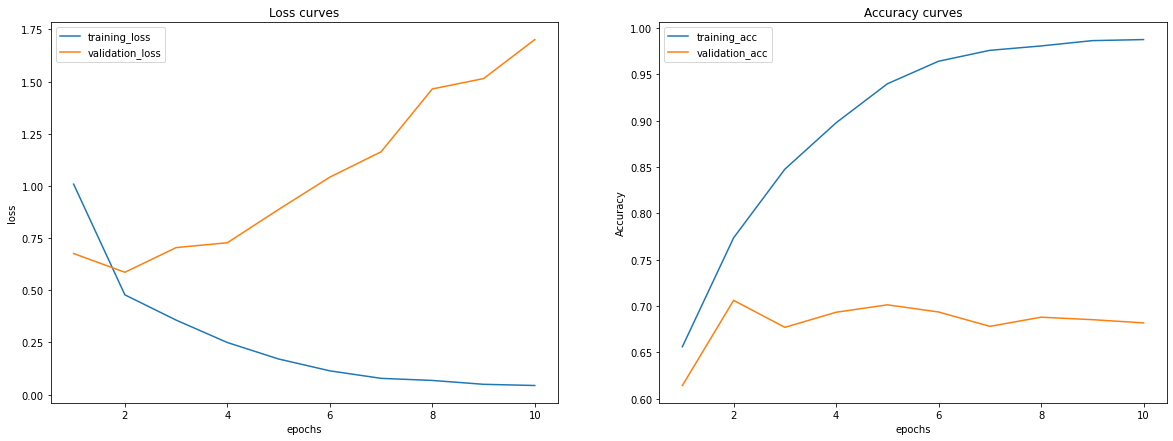

In [23]:
plot_loss_curves(fit_1)

## Predictions

In [33]:
y_pred = model_1.predict(
    X_test,
    batch_size=1,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

4682/4682 [==============================] - 52s 11ms/step


In [35]:
y_test

array([0, 1, 1, ..., 1, 0, 0])

In [36]:
y_pred

array([[0.6918573 ],
       [0.24316752],
       [0.01069097],
       ...,
       [0.6658586 ],
       [0.996111  ],
       [0.00108771]], dtype=float32)

In [44]:
def predict_classes(x): 
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

In [38]:
print(predict_classes(y_pred))

prediction_index = predict_classes(y_pred)

[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [45]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt


In [ ]:


def model_eval_metrics(y_true, y_pred):
    accuracy_eval = accuracy_score(y_true, y_pred)
    f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
    precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
    recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
    metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval]}
    finalmetricdata = pd.DataFrame.from_dict(metricdata)
    
    return finalmetricdata

In [46]:
model_eval_metrics(y_test, prediction_index)

,accuracy,f1_score,precision,recall
0,0.684323,0.683435,0.686142,0.684171


In [47]:
accuracy_score(y_test, prediction_index, normalize=True)

0.6843229389149936

# Model 2

## Building and compiling

In [29]:
model_2 = Sequential()

model_2.add(Conv2D(16, (3, 3),padding="same", input_shape = X_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3), padding="same"))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())  
model_2.add(Dense(10))

model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

In [30]:
print("Number of layers in the model: ", len(model_2.layers))
print("Number of parameters in the model: ", model_2.count_params())

Number of layers in the model:  10
Number of parameters in the model:  652821


In [38]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_5 (Activation)   (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [39]:
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Fitting

In [40]:
fit_2 = model_2.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, 
          use_multiprocessing=True, workers = 4)

Epoch 1/10
469/469 [==============================] - 30s 61ms/step - loss: 0.6348 - accuracy: 0.6540 - val_loss: 0.5552 - val_accuracy: 0.7162
Epoch 2/10
469/469 [==============================] - 29s 62ms/step - loss: 0.4839 - accuracy: 0.7696 - val_loss: 0.5011 - val_accuracy: 0.7501
Epoch 3/10
469/469 [==============================] - 29s 62ms/step - loss: 0.4004 - accuracy: 0.8151 - val_loss: 0.5018 - val_accuracy: 0.7563
Epoch 4/10
469/469 [==============================] - 29s 62ms/step - loss: 0.3171 - accuracy: 0.8607 - val_loss: 0.5592 - val_accuracy: 0.7504
Epoch 5/10
469/469 [==============================] - 29s 61ms/step - loss: 0.2381 - accuracy: 0.9030 - val_loss: 0.6291 - val_accuracy: 0.7557
Epoch 6/10
469/469 [==============================] - 29s 62ms/step - loss: 0.1777 - accuracy: 0.9286 - val_loss: 0.7245 - val_accuracy: 0.7459
Epoch 7/10
469/469 [==============================] - 29s 61ms/step - loss: 0.1145 - accuracy: 0.9582 - val_loss: 0.8963 - val_accuracy:

## Loss and accuracy curves

In [41]:
def plot_loss_curves(fit_2):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=fit_2.history['loss']
    val_loss=fit_2.history['val_loss']

    train_accuracy=fit_2.history['accuracy']
    val_accuracy=fit_2.history['val_accuracy']

    epochs=range(1,len(fit_2.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

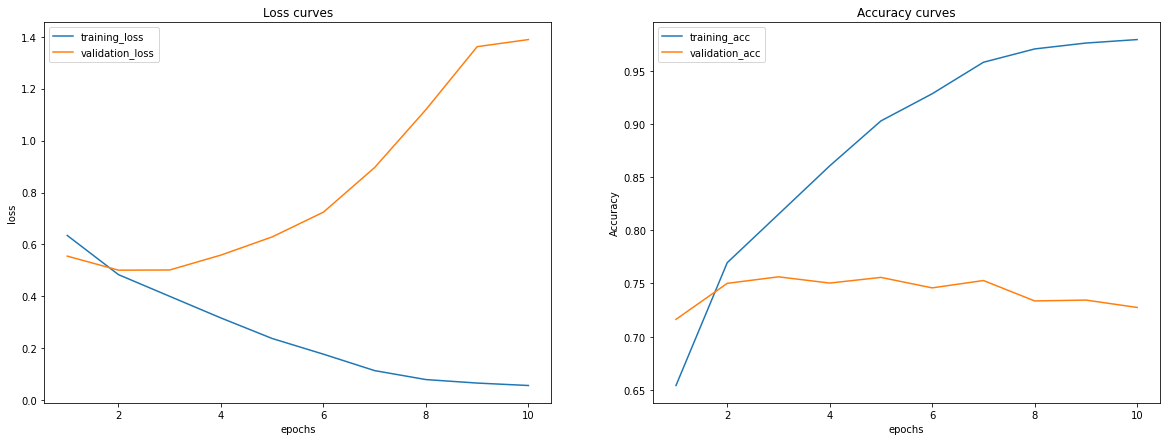

In [42]:
plot_loss_curves(fit_2)


## Predictions

In [43]:
y_pred_2 = model_2.predict(
    X_test,
    batch_size=1,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

4682/4682 [==============================] - 21s 4ms/step


In [44]:
y_test

array([1, 1, 0, ..., 0, 1, 1])

In [45]:
y_pred_2

array([[0.3451625 ],
       [0.9880371 ],
       [0.9925793 ],
       ...,
       [0.00102456],
       [0.740616  ],
       [0.9959992 ]], dtype=float32)

In [46]:
print(predict_classes(y_pred_2))

prediction_index_2 = predict_classes(y_pred_2)

[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]


In [47]:
def model_eval_metrics_2(y_true, y_pred_2):
    accuracy_eval = accuracy_score(y_true, y_pred_2)
    f1_score_eval = f1_score(y_true, y_pred_2,average="macro",zero_division=0)
    precision_eval = precision_score(y_true, y_pred_2,average="macro",zero_division=0)
    recall_eval = recall_score(y_true, y_pred_2,average="macro",zero_division=0)
    metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval]}
    finalmetricdata_2 = pd.DataFrame.from_dict(metricdata)
    
    return finalmetricdata_2

In [48]:
model_eval_metrics_2(y_test, prediction_index_2)

,accuracy,f1_score,precision,recall
0,0.73601,0.735975,0.73621,0.736051


# Model with hyperparameter tuning

In [15]:
import time
from tensorflow.keras.callbacks import TensorBoard

In [16]:
%load_ext tensorboard

In [17]:
rm -rf ./logs/

In [18]:
NAME = 'Cats-vs-dog-cnn{}'.format(int(time.time()))

In [19]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [20]:
dense_layers = [0,1, 2] 
layer_sizes = [32, 64, 128]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

3-conv-32-nodes-0-dense-1657025674
3-conv-64-nodes-0-dense-1657025674
3-conv-128-nodes-0-dense-1657025674
3-conv-32-nodes-1-dense-1657025674
3-conv-64-nodes-1-dense-1657025674
3-conv-128-nodes-1-dense-1657025674
3-conv-32-nodes-2-dense-1657025674
3-conv-64-nodes-2-dense-1657025674
3-conv-128-nodes-2-dense-1657025674


## Builgind, compiling and fitting

In [21]:
dense_layers = [0] # 1,2 
layer_sizes = [32] # 64, 128
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model_t = Sequential()

            model_t.add(Conv2D(layer_size, (3, 3), input_shape=(180, 180, 1)))
            model_t.add(Activation('relu'))
            model_t.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model_t.add(Conv2D(layer_size, (3, 3)))
                model_t.add(Activation('relu'))
                model_t.add(MaxPooling2D(pool_size=(2, 2)))

            model_t.add(Flatten())

            for _ in range(dense_layer):
                model_t.add(Dense(layer_size))
                model_t.add(Activation('relu'))

            model_t.add(Dense(1))
            model_t.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model_t.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            fit_t = model_t.fit(X_train, y_train,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.2,
                      use_multiprocessing=True,
                      workers=4,
                      callbacks=[tensorboard])



3-conv-32-nodes-0-dense-1657025676
Epoch 1/10
469/469 [==============================] - 41s 83ms/step - loss: 0.6449 - accuracy: 0.6201 - val_loss: 0.6322 - val_accuracy: 0.6559
Epoch 2/10
469/469 [==============================] - 36s 77ms/step - loss: 0.5351 - accuracy: 0.7294 - val_loss: 0.5133 - val_accuracy: 0.7448
Epoch 3/10
469/469 [==============================] - 35s 76ms/step - loss: 0.4778 - accuracy: 0.7693 - val_loss: 0.4777 - val_accuracy: 0.7734
Epoch 4/10
469/469 [==============================] - 36s 77ms/step - loss: 0.4359 - accuracy: 0.7995 - val_loss: 0.4722 - val_accuracy: 0.7776
Epoch 5/10
469/469 [==============================] - 36s 76ms/step - loss: 0.4087 - accuracy: 0.8168 - val_loss: 0.4516 - val_accuracy: 0.7875
Epoch 6/10
469/469 [==============================] - 35s 75ms/step - loss: 0.3774 - accuracy: 0.8296 - val_loss: 0.4859 - val_accuracy: 0.7766
Epoch 7/10
469/469 [==============================] - 36s 76ms/step - loss: 0.3467 - accuracy: 0.8463

In [23]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 2718), started 0:00:02 ago. (Use '!kill 2718' to kill it.)

In [84]:
def plot_loss_curves(fit_t):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=fit_t.history['loss']
    val_loss=fit_t.history['val_loss']

    train_accuracy=fit_t.history['accuracy']
    val_accuracy=fit_t.history['val_accuracy']

    epochs=range(1,len(fit_t.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

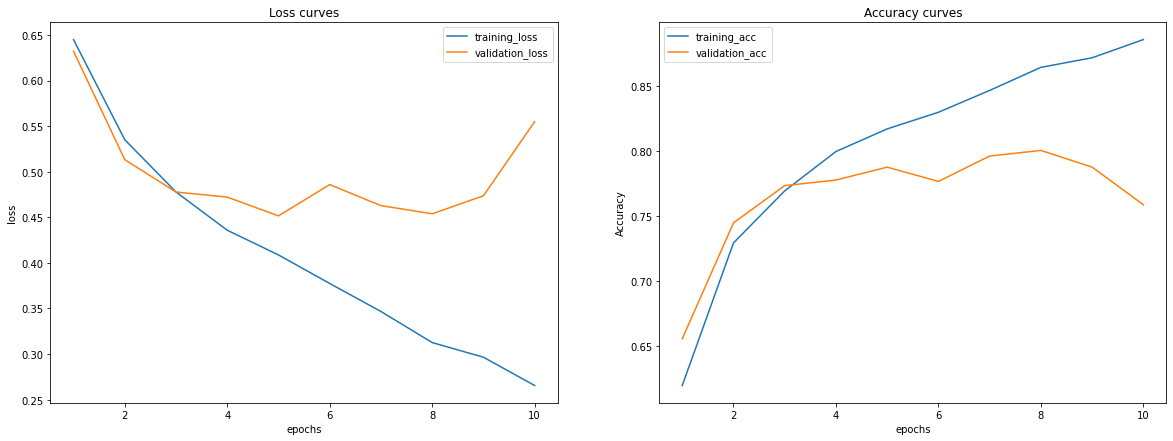

In [85]:
plot_loss_curves(fit_t)

## Predictions

In [25]:
y_pred_t = model_t.predict(
    X_test,
    batch_size=1,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

4682/4682 [==============================] - 10s 2ms/step


In [26]:
y_test

array([1, 1, 0, ..., 0, 1, 1])

In [27]:
y_pred_t

array([[0.6619294 ],
       [0.3985105 ],
       [0.4042531 ],
       ...,
       [0.00598863],
       [0.74172235],
       [0.4740631 ]], dtype=float32)

In [30]:
print(predict_classes(y_pred_t))

prediction_index_t = predict_classes(y_pred_t)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [34]:
def model_eval_metrics_t(y_true, y_pred_t):
    accuracy_eval = accuracy_score(y_true, y_pred_t)
    f1_score_eval = f1_score(y_true, y_pred_t,average="macro",zero_division=0)
    precision_eval = precision_score(y_true, y_pred_t,average="macro",zero_division=0)
    recall_eval = recall_score(y_true, y_pred_t,average="macro",zero_division=0)
    metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval]}
    finalmetricdata_t = pd.DataFrame.from_dict(metricdata)
    
    return finalmetricdata_t

In [35]:
model_eval_metrics_t(y_test, prediction_index_t)

,accuracy,f1_score,precision,recall
0,0.755446,0.74954,0.780984,0.754994


# Model 4

## Building, compiling and fitting

In [15]:
model_4 = Sequential()

model_4.add(Conv2D(16, (3, 3), padding="same",input_shape = X_train.shape[1:]))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3), padding="same"))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(64, (3, 3), padding="same"))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Flatten()) 
model_4.add(Dense(10))

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

In [16]:
print("Number of layers in the model: ", len(model_4.layers))
print("Number of parameters in the model: ", model_4.count_params())

Number of layers in the model:  13
Number of parameters in the model:  333077


In [17]:
import keras

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.0001) # set optimizer and learning rate

In [19]:
model_4.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [36]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 activation_9 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_10 (Activation)  (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [20]:
fit_4 = model_4.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, 
          use_multiprocessing=True, workers = 4)

Epoch 1/10
469/469 [==============================] - 33s 68ms/step - loss: 0.6438 - accuracy: 0.6217 - val_loss: 0.5947 - val_accuracy: 0.6829
Epoch 2/10
469/469 [==============================] - 30s 64ms/step - loss: 0.5661 - accuracy: 0.7073 - val_loss: 0.5517 - val_accuracy: 0.7258
Epoch 3/10
469/469 [==============================] - 29s 62ms/step - loss: 0.5199 - accuracy: 0.7428 - val_loss: 0.5240 - val_accuracy: 0.7472
Epoch 4/10
469/469 [==============================] - 29s 62ms/step - loss: 0.4861 - accuracy: 0.7639 - val_loss: 0.5066 - val_accuracy: 0.7603
Epoch 5/10
469/469 [==============================] - 29s 61ms/step - loss: 0.4596 - accuracy: 0.7834 - val_loss: 0.4938 - val_accuracy: 0.7680
Epoch 6/10
469/469 [==============================] - 29s 61ms/step - loss: 0.4405 - accuracy: 0.7930 - val_loss: 0.4912 - val_accuracy: 0.7771
Epoch 7/10
469/469 [==============================] - 30s 63ms/step - loss: 0.4226 - accuracy: 0.8046 - val_loss: 0.4979 - val_accuracy:

## Loss and accuracy curves

In [38]:
def plot_loss_curves(fit_4):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=fit_4.history['loss']
    val_loss=fit_4.history['val_loss']

    train_accuracy=fit_4.history['accuracy']
    val_accuracy=fit_4.history['val_accuracy']

    epochs=range(1,len(fit_4.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

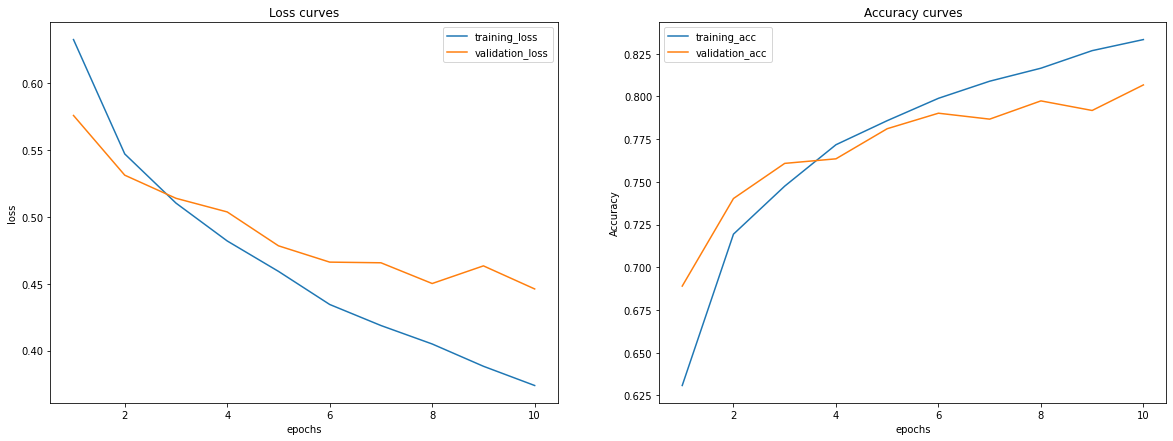

In [39]:
plot_loss_curves(fit_4)

## Predictions

In [40]:
y_pred_4 = model_4.predict(
    X_test,
    batch_size=1,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)


4682/4682 [==============================] - 15s 3ms/step


In [41]:
y_test

array([0, 1, 0, ..., 0, 0, 0])

In [42]:
y_pred_4

array([[0.2612263 ],
       [0.5957285 ],
       [0.02517663],
       ...,
       [0.06953458],
       [0.0386958 ],
       [0.10028849]], dtype=float32)

In [46]:
print(predict_classes(y_pred_4))

prediction_index_4 = predict_classes(y_pred_4)

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [48]:
def model_eval_metrics_4(y_true, y_pred_4):
    accuracy_eval = accuracy_score(y_true, y_pred_4)
    f1_score_eval = f1_score(y_true, y_pred_4,average="macro",zero_division=0)
    precision_eval = precision_score(y_true, y_pred_4,average="macro",zero_division=0)
    recall_eval = recall_score(y_true, y_pred_4,average="macro",zero_division=0)
    metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval]}
    finalmetricdata_4 = pd.DataFrame.from_dict(metricdata)
    
    return finalmetricdata_4

In [49]:
model_eval_metrics_4(y_test, prediction_index_4)

,accuracy,f1_score,precision,recall
0,0.781504,0.780823,0.784693,0.781344


# Testing the best model with a new image

In [21]:
from keras.preprocessing import image

In [22]:
#Using cat picture from the web
picture_url = "https://placekitten.com/g/200/300"
picture_path = tf.keras.utils.get_file("300", origin=picture_url)

In [28]:
img_height=180
img_width=180

In [41]:
new_predic = model_4.predict(img_array)
new_predic

1/1 [==============================] - 0s 10ms/step


array([[0.]], dtype=float32)